# Tutorial on RePaint

- First, modify the execution : Exécution > Modifier le type d'exécution > Accélérateur matériel > GPU

# Downloading the packages


In [1]:
! git clone https://github.com/andreas128/RePaint

Cloning into 'RePaint'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 85 (delta 43), reused 46 (delta 23), pack-reused 6
Unpacking objects: 100% (85/85), 52.06 KiB | 1.33 MiB/s, done.


In [8]:
import os
os.chdir('RePaint')

In [ ]:
!bash download.sh

In [ ]:
!pip install blobfile

# Inside the code

In [12]:
import argparse
import torch as th
import torch.nn.functional as F
import time
import conf_mgt
from utils import yamlread
from guided_diffusion import dist_util
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    select_args)
import sys
sys.argv=['']
del sys

from torchvision.transforms.functional import to_tensor, to_pil_image
from IPython.display import display
from PIL import Image
import torch

In [13]:
parser = argparse.ArgumentParser()
parser.add_argument('--conf_path', type=str, required=False, default=None)
args = vars(parser.parse_args())
args['conf_path'] = 'confs/face_example.yml'
conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread(args.get('conf_path')))
args['conf_path'] = 'confs/face_example.yml'

In [ ]:
conf = conf_arg

device = dist_util.dev(conf.get('device'))
print("device :")
print(device)

model, diffusion = create_model_and_diffusion(**select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
model.to(device)

model.eval()

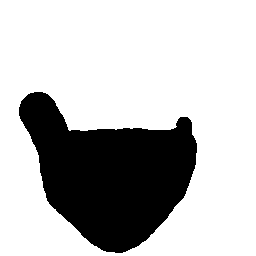

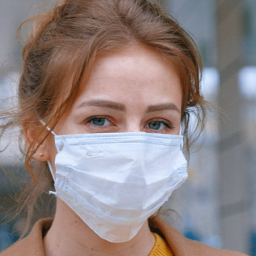

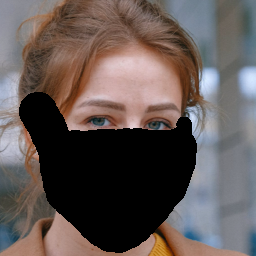

In [15]:
os.chdir('/content/RePaint/data/datasets/gt_keep_masks/face')

mask = Image.open('000002.png')
display(mask)

os.chdir('/content/RePaint/data/datasets/gts/face')

img = Image.open('000002.png')
display(img)

img_masked = to_pil_image(to_tensor(img)*to_tensor(mask))
display(img_masked)

In [26]:
nb_samples = 2


conf.schedule_jump_params = {'t_T': 250, 'n_sample': 1, 'jump_length': 1, 'jump_n_sample': 1}
show_progress = conf.show_progress
batch = {}

batch['GT'] = torch.stack([to_tensor(img)]*nb_samples).to(device)

model_kwargs = {}

model_kwargs["gt"] = batch['GT']

model_kwargs['gt_keep_mask'] = to_tensor(mask).to(device)

def model_fn(x, t, y=None, gt=None, **kwargs):
        return model(x, t,None, gt=gt)

#Default : use_ddim is False.
sample_fn = diffusion.p_sample_loop

result = sample_fn(
    model_fn,
    (nb_samples, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    device=device,
    progress=True,
    return_all=True,
    conf=conf)

  0%|          | 0/250 [00:00<?, ?it/s]

Samples


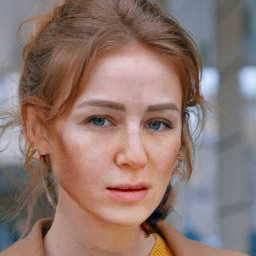

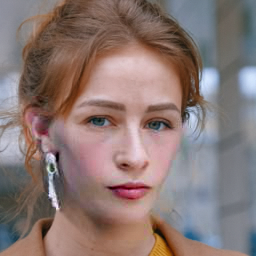

GT


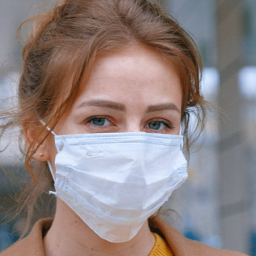

Masked


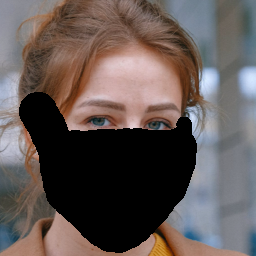

In [27]:
print('Samples')
for k in range (nb_samples) :
    display(to_pil_image(result['sample'][k,:,:,:].cpu().clip(0,1)))
print('GT')
display(img)
print('Masked')
display(img_masked)

# Setting for generation

In [39]:
nb_samples = 5

In [40]:
conf['schedule_jump_params'] = {'t_T': 250, 'n_sample': 1, 'jump_length': 1, 'jump_n_sample': 1}
show_progress = conf.show_progress
batch = {}
batch_size = 1
img_GT = torch.unsqueeze(to_tensor(img),dim=0)
batch['GT'] = torch.stack([to_tensor(img)]*nb_samples).to(device)

model_kwargs = {}

model_kwargs["gt"] = batch['GT']

model_kwargs['gt_keep_mask'] = 0.*to_tensor(mask).to(device)

def model_fn(x, t, y=None, gt=None, **kwargs):
        return model(x, t,None, gt=gt)

#Default : use_ddim is False.
sample_fn = diffusion.p_sample_loop

result = sample_fn(
    model_fn,
    (nb_samples, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    device=device,
    progress=True,
    return_all=True,
    conf=conf)

for k in range (nb_samples) :
    result['sample'][k,:,:,:] = (result['sample'][k,:,:,:]+1)/2

  0%|          | 0/250 [00:00<?, ?it/s]

Samples


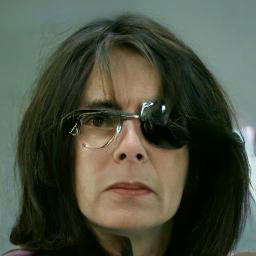

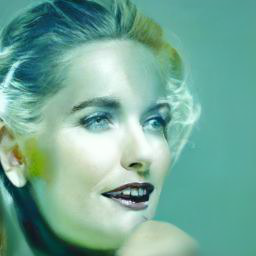

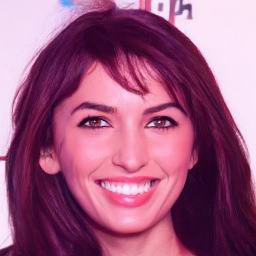

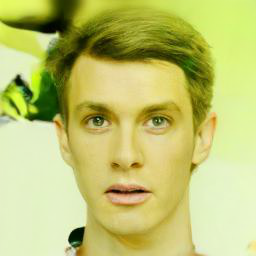

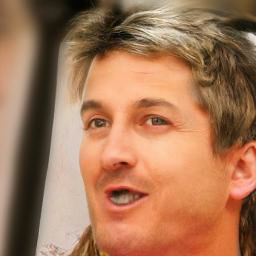

In [41]:
print('Samples')
for k in range (nb_samples) :
    display(to_pil_image(result['sample'][k,:,:,:].cpu().clip(0,1)))

# Observation of the parameters

In [33]:
conf.keys()

dict_keys(['attention_resolutions', 'class_cond', 'diffusion_steps', 'learn_sigma', 'noise_schedule', 'num_channels', 'num_head_channels', 'num_heads', 'num_res_blocks', 'resblock_updown', 'use_fp16', 'use_scale_shift_norm', 'classifier_scale', 'lr_kernel_n_std', 'num_samples', 'show_progress', 'timestep_respacing', 'use_kl', 'predict_xstart', 'rescale_timesteps', 'rescale_learned_sigmas', 'classifier_use_fp16', 'classifier_width', 'classifier_depth', 'classifier_attention_resolutions', 'classifier_use_scale_shift_norm', 'classifier_resblock_updown', 'classifier_pool', 'num_heads_upsample', 'channel_mult', 'dropout', 'use_checkpoint', 'use_new_attention_order', 'clip_denoised', 'use_ddim', 'latex_name', 'method_name', 'image_size', 'model_path', 'name', 'inpa_inj_sched_prev', 'n_jobs', 'print_estimated_vars', 'inpa_inj_sched_prev_cumnoise', 'schedule_jump_params', 'data'])

In [36]:
print('learn_sigma')
print(conf['learn_sigma'])
print('noise_schedule')
print(conf['noise_schedule'])
print('schedule_jump_params')
print(conf['schedule_jump_params'])

learn_sigma
True
noise_schedule
linear
schedule_jump_params
{'t_T': 250, 'n_sample': 1, 'jump_length': 10, 'jump_n_sample': 10}


# Further examples

I put my data at the url : https://github.com/emilePi/GT_DL

To generate mask on an image, you can use : https://ipolcore.ipol.im/demo/clientApp/demo.html?id=198

# For information: Code execution for an example

In [ ]:
!cd RePaint

In [ ]:
!python RePaint/test.py --conf_path RePaint/confs/face_example.yml

Start face_example
sampling...
  0% 2/4570 [01:40<62:29:04, 49.24s/it]